In [1]:
!apt-get update -y
!apt-get install -y p7zip-full


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,937 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,521 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,575 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa

In [2]:
download_links = {
    "ch3.7z": "https://zenodo.org/records/6299967/files/ch3_data.7z?download=1",
    "ch11.7z": "https://zenodo.org/records/6299967/files/ch11_data.7z?download=1",
    "ch14.7z": "https://zenodo.org/records/6299967/files/ch14_data.7z?download=1",
    "ch16.7z": "https://zenodo.org/records/6299967/files/ch16_data.7z?download=1"
}

for filename, url in download_links.items():
  !wget -O "{filename}" "{url}"
  !7z x "{filename}"

  print(f"Finished with {filename}\n")

print("All required channel files have been downloaded and unzipped.")

--2025-08-16 18:37:30--  https://zenodo.org/records/6299967/files/ch3_data.7z?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47772151 (46M) [application/octet-stream]
Saving to: ‘ch3.7z’

ch3.7z              100%[===================>]  45.56M  21.1MB/s    in 2.2s    

2025-08-16 18:37:33 (21.1 MB/s) - ‘ch3.7z’ saved [47772151/47772151]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs AMD EPYC 7B12 (830F10),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 47772151 bytes (46 MiB)

Extracting archive: ch3.7z
--
Path = ch3.7z
Type = 7z
Physical Size = 47772151
Headers Size = 130
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      2% - ch3_data.pkl        

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import gc

In [4]:
channels = {
    '54 keV': 'ch3_data.pkl',
    '235 keV': 'ch11_data.pkl',
    '597 keV': 'ch14_data.pkl',
    '909 keV': 'ch16_data.pkl'
}

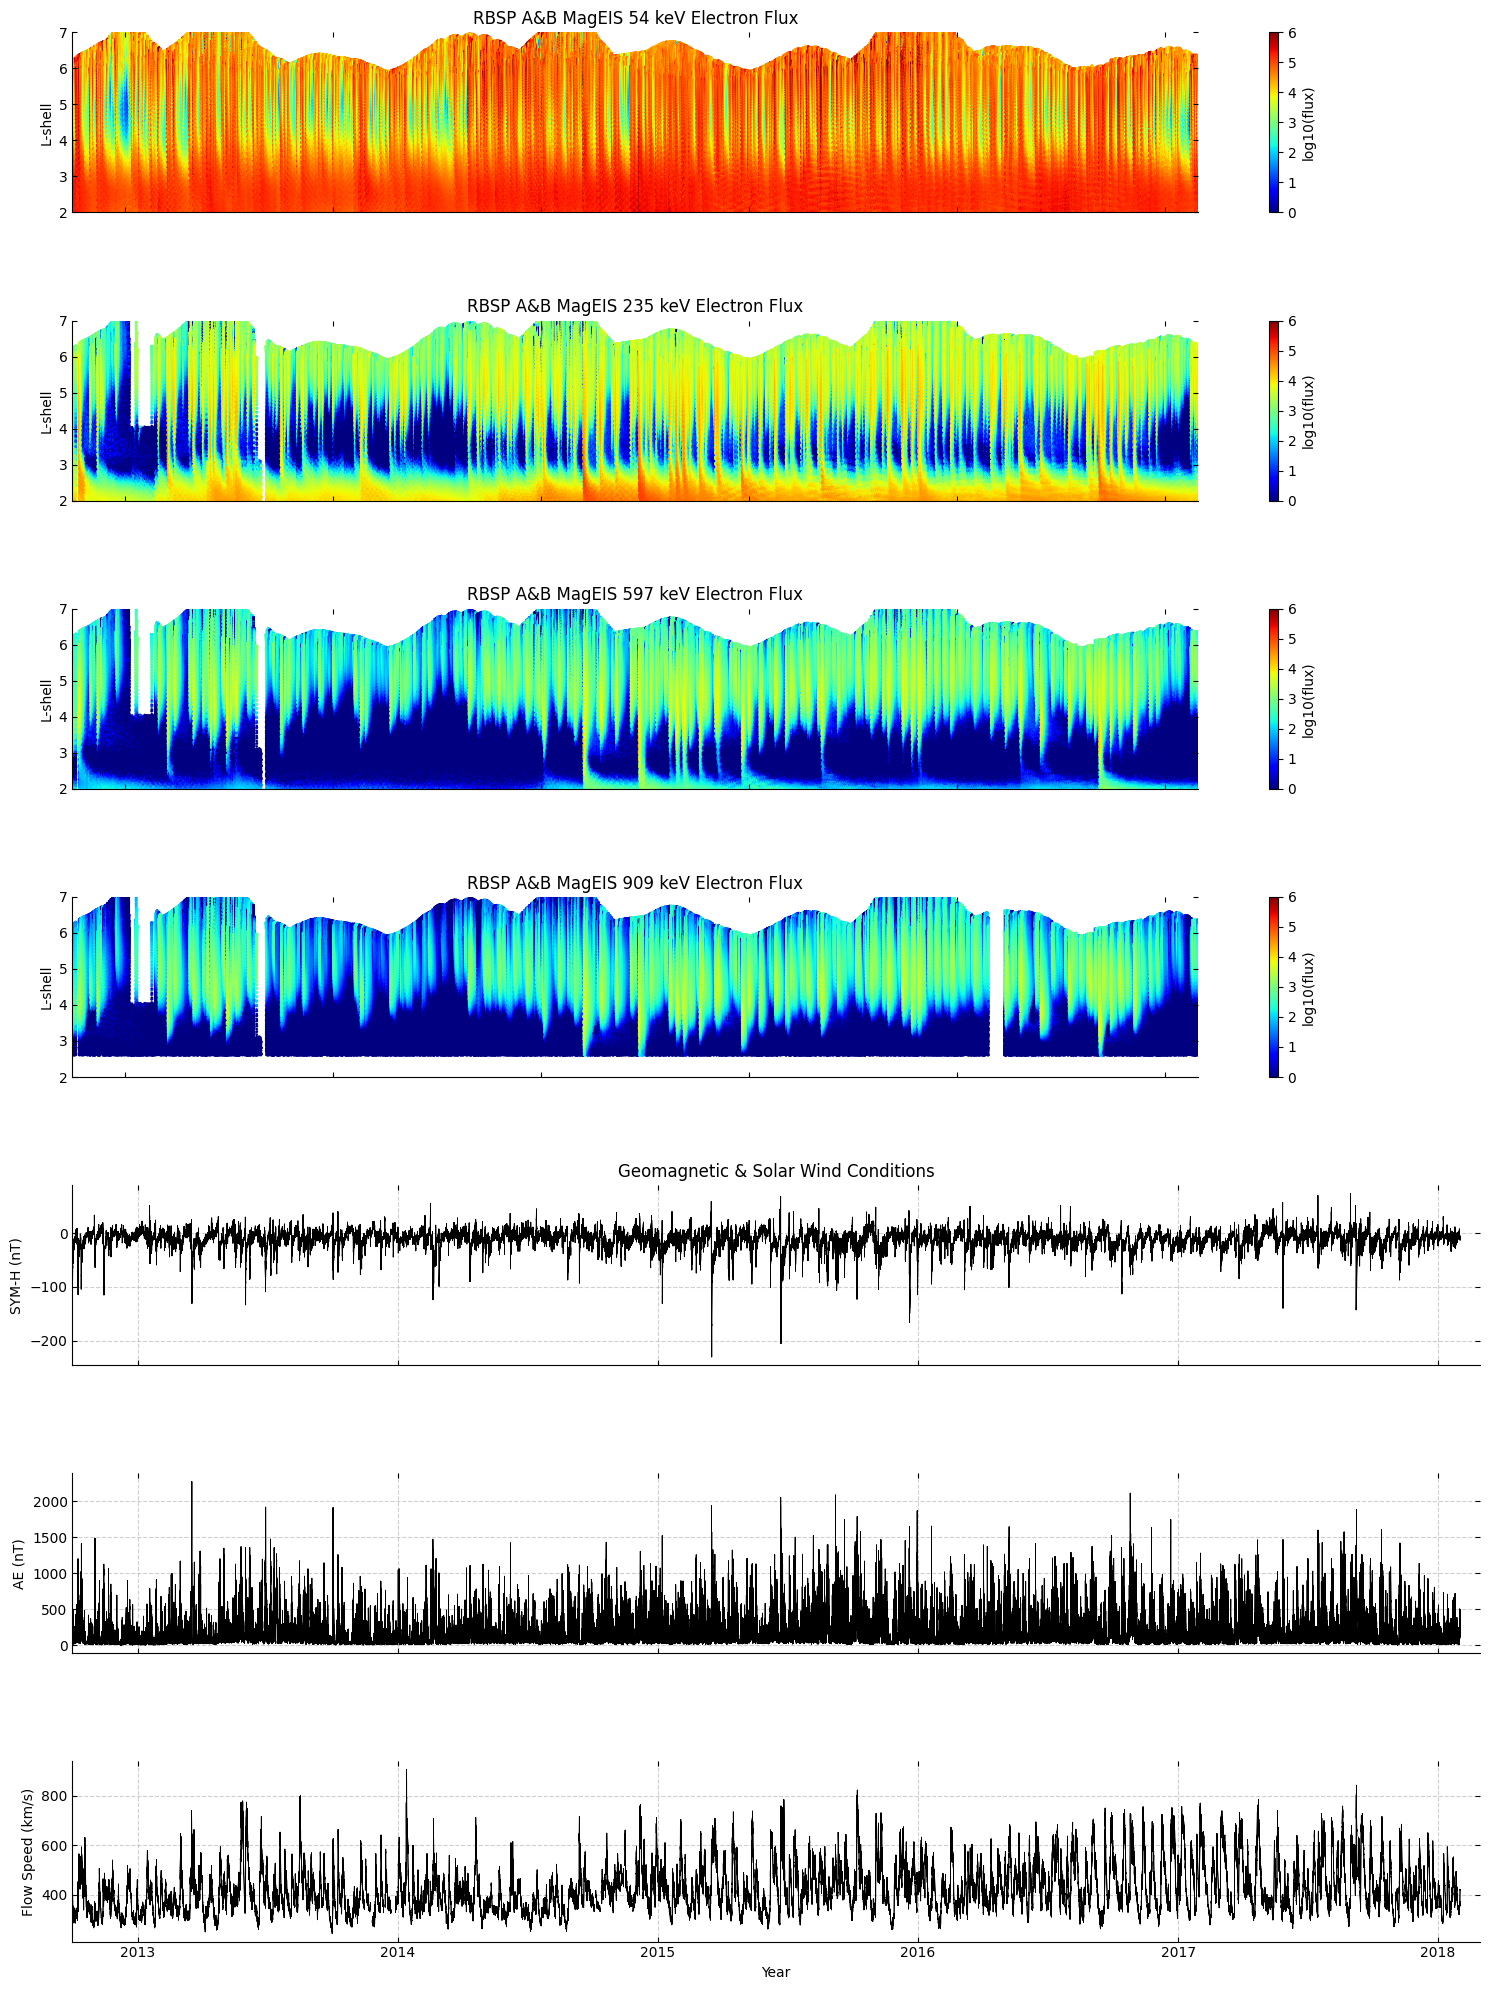

177

In [5]:
time_col = 'unix_time'
l_shell_col = 'Lm_eq_OP77Q_intxt'
flux_col = 'eflux'
sym_h_col = 'SYM_H_t_0'
ae_index_col = 'AE_INDEX_t_0'
flow_speed_col = 'flow_speed_t_0'

fig, axes = plt.subplots(7, 1, figsize=(15, 20), sharex=True)

# Electron flux panels
for i, (label, file) in enumerate(channels.items()):
    df = pd.read_pickle(file)
    df['datetime'] = pd.to_datetime(df[time_col], unit='s')
    log_flux = np.log10(df[flux_col] + 1e-1)
    sc = axes[i].scatter(
        df['datetime'],
        df[l_shell_col],
        c=log_flux,
        s=1,
        cmap='jet',
        norm=colors.Normalize(vmin=0, vmax=6)
    )
    axes[i].set_ylabel('L-shell')
    axes[i].set_ylim(2, 7)
    axes[i].set_title(f'RBSP A&B MagEIS {label} Electron Flux')
    fig.colorbar(sc, ax=axes[i], label='log10(flux)')
    del df
    gc.collect()

# Geomagnetic & solar wind panels
df_idx = pd.read_pickle(channels['54 keV'])
df_idx['datetime'] = pd.to_datetime(df_idx[time_col], unit='s')

axes[4].plot(df_idx['datetime'], df_idx[sym_h_col], color='black', linewidth=0.5)
axes[4].set_ylabel('SYM-H (nT)')
axes[4].set_title('Geomagnetic & Solar Wind Conditions')
axes[4].grid(True, linestyle='--', alpha=0.6)

index_col = 'AL_INDEX_t_0' if 'AL_INDEX_t_0' in df_idx.columns else ae_index_col
axes[5].plot(df_idx['datetime'], df_idx[index_col], color='black', linewidth=0.5)
axes[5].set_ylabel(f'{index_col.split("_")[0]} (nT)')
axes[5].grid(True, linestyle='--', alpha=0.6)

axes[6].plot(df_idx['datetime'], df_idx[flow_speed_col], color='black', linewidth=0.5)
axes[6].set_ylabel('Flow Speed (km/s)')
axes[6].set_xlabel('Year')
axes[6].grid(True, linestyle='--', alpha=0.6)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in', which='both', top=True, right=True)

axes[6].xaxis.set_major_locator(mdates.YearLocator())
axes[6].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([pd.to_datetime("2012-10-01"), pd.to_datetime("2018-03-01")])
plt.tight_layout()
plt.subplots_adjust(hspace=0.6)

plt.savefig('figure1.png', dpi=300, bbox_inches='tight')
plt.show()

del df_idx
gc.collect()
